In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%run data_intake.ipynb
import os

In [4]:
aquastat_file_names = [fn for fn in os.listdir("data/") if ".xlsx" in fn]

aquastat_crop_yield = pipeline(aquastat_file_names, "Attainable_yields.csv", "value")

aquastat_crop_yield

,Country,Year,total_renewable_water_resources,agricultural_value_added_percent_of_gdp,total_exploitable_water_resources,precipitation_index,gdp_per_capita,total_internal_renewable_water_resource_per_capita,arable_land_area,total_population,total_yield
59,Albania,2018,30.2,18.429476,13.0,1136.00,5257.650696,9331.399988,611.346,2882.740,87.14
60,Albania,2017,30.2,19.022127,13.0,1136.00,4514.204908,9326.776621,612.000,2884.169,69.81
61,Albania,2016,30.2,19.849993,13.0,1136.00,4109.340457,9319.444935,620.300,2886.438,68.46
62,Albania,2015,30.2,19.780225,13.0,1136.00,3939.413126,9306.306528,615.100,2890.513,71.04
63,Albania,2014,30.2,19.990153,13.0,1136.00,4567.281443,9287.695875,615.600,2896.305,68.50
...,...,...,...,...,...,...,...,...,...,...,...
10432,Zimbabwe,1974,20.0,13.822747,1.5,746.72,811.510083,2014.765967,2465.000,6085.074,141.67
10433,Zimbabwe,1973,20.0,11.305693,1.5,712.18,698.192005,2085.840681,2415.000,5877.726,112.67
10434,Zimbabwe,1972,20.0,13.466776,1.5,677.64,588.037380,2160.767062,2415.000,5673.911,125.86
10435,Zimbabwe,1971,20.0,13.129246,1.5,643.10,493.287110,2238.459064,2385.000,5476.982,132.97


In [5]:
# descends the model by a single step
def descend(true_y, pred_y, x, b, alpha=0.01):
    return b - alpha*np.sum(np.subtract(pred_y, true_y)*x)/true_y.size

In [6]:
# Returns a list of predictions for total yield when given X values and b values
def predict(X, b):
    return np.add(np.matmul(X.loc[:, X.columns != 'b0'],b[1:]), b[0])

In [7]:
def mse(true, pred):
    return np.square(np.subtract(true,pred)).mean()

In [8]:
def lin_regression(data, alpha=0.00001, epochs=1000, stats=True, y_col='total_yield', print_=False):
    # generates initial w values
    b = np.zeros(len(data.axes[1]))
    #b = random.rand(len(data.axes[1]))
    
    # removes outcome from data, and inserts a dummy column for w0
    fdata = data.loc[:, data.columns != y_col]
    fdata.insert(0, 'b0', np.ones(len(data)))
    
    if stats:
        mse_list = []
    
    for i in range(epochs):

        pred = predict(fdata, b)
        
        if print_:
            print(b, pred)
        
        # Ends early if the value increases too much
        if math.isnan(pred[0]) or math.isinf(pred[0]):
            print("Value increased to infinity")
            if stats:
                return b, mse_list
            else:
                return b
        
        if stats:
            # Calculates mpe and acc for each epoch
            mse_list.append(mse(data[y_col], pred))
        
        index = 0
        for col in fdata:
            b[index] = descend(data[y_col], pred, fdata[col], b[index], alpha=alpha)
            index +=1
    
    if stats:
        return b, mse_list
    else:
        return b

In [9]:
def pipeline_separate(aquastat_filenames, crop_yield_filename, aquastat_feature):
    """
    Runs the aquastat and crop yield pipeline
    """
    shared_attributes = ["Country", "Year"]
    crop_df = crop_yield_specialized_preprocessing(convert_to_pandas(crop_yield_filename))
    dfs = []
    for fn in aquastat_filenames:
        temp_df = convert_to_pandas(fn)
        strip_temp_df = strip_df(temp_df, shared_attributes + [aquastat_feature])
        renamed_temp_df = aquastat_feature_rename(strip_temp_df, fn, aquastat_feature)
        dfs.append(strip_temp_df)
    
    dfs.append(crop_df)
    
    return dfs

In [61]:
dfs = pipeline_separate(aquastat_file_names, "Attainable_yields.csv", "value")
dfs

[           Country  Year  total_renewable_water_resources
 0      Afghanistan  2020                            65.33
 1      Afghanistan  2019                            65.33
 2      Afghanistan  2018                            65.33
 3      Afghanistan  2017                            65.33
 4      Afghanistan  2016                            65.33
 ...            ...   ...                              ...
 10438     Zimbabwe  1968                            20.00
 10439     Zimbabwe  1967                            20.00
 10440     Zimbabwe  1966                            20.00
 10441     Zimbabwe  1965                            20.00
 10442     Zimbabwe  1964                            20.00
 
 [10443 rows x 3 columns],
           Country  Year  agricultural_value_added_percent_of_gdp
 0     Afghanistan  2020                                27.013561
 1     Afghanistan  2019                                25.773971
 2     Afghanistan  2018                                22.042897

In [101]:
def test_combos(dfs, yield_df, combination_size=2, alpha_vals=[0.001, 0.0001]):
    results = []
    for size in range(combination_size):
        combs = itertools.combinations(dfs, size)
    
        # Iterates through the list of combination
        for comb in combs:
            data = yield_df
        
            # Merges all the dataframes in the combination into 1
            for df in comb:
                data = data.merge(df, on=["Country", "Year"])
            
            data = data.drop(["Country", "Year"], axis=1)
        
            # Runs linear regression using the given alpha levels
            for alpha in alpha_vals:
                beta, mse_list = lin_regression(data, epochs=1000, alpha=alpha)
                mse_val = mse_list[-1]
            
                # Ensures mse_val is a number
                if math.isnan(mse_val) or math.isinf(mse_val):
                    mse_val = 99999999
                
                results.append((mse_val, beta, alpha, data.axes[1]))
            
            
    return results

In [102]:
combos = test_combos(dfs[:-1], dfs[-1], combination_size=3, alpha_vals=[0.001, 0.0001, 0.00001])

C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


In [105]:
valid_combos = [combo for combo in combos if combo[0] < 99999999]
valid_combos

[(3054.4387665004588,
  array([45.3848944]),
  0.001,
  Index(['total_yield'], dtype='object')),
 (6575.348571806306,
  array([6.83080472]),
  0.0001,
  Index(['total_yield'], dtype='object')),
 (7406.519053203893,
  array([0.71419615]),
  1e-05,
  Index(['total_yield'], dtype='object')),
 (3278.119111582906,
  array([27.57768629,  1.52490335]),
  0.001,
  Index(['total_yield', 'agricultural_value_added_percent_of_gdp'], dtype='object')),
 (4591.935393496022,
  array([3.43819034, 2.39669109]),
  0.0001,
  Index(['total_yield', 'agricultural_value_added_percent_of_gdp'], dtype='object')),
 (4793.404671043973,
  array([0.43118005, 2.46670393]),
  1e-05,
  Index(['total_yield', 'agricultural_value_added_percent_of_gdp'], dtype='object')),
 (5975.200366754301,
  array([6.34644768, 0.28569195]),
  0.0001,
  Index(['total_yield', 'dam_capacity'], dtype='object')),
 (6693.109138373888,
  array([0.66150025, 0.30166047]),
  1e-05,
  Index(['total_yield', 'dam_capacity'], dtype='object')),
 (218

In [81]:
final_df = dfs[-1].merge(dfs[4], on=["Country", "Year"]).merge(dfs[0], on=["Country", "Year"])
final_df

,Country,Year,total_yield,gdp_per_capita,total_renewable_water_resources
0,Afghanistan,1970,33.03,154.957138,65.33
1,Afghanistan,1971,33.16,157.975357,65.33
2,Afghanistan,1972,33.15,139.756605,65.33
3,Afghanistan,1973,33.57,140.616194,65.33
4,Afghanistan,1974,35.40,166.095029,65.33
...,...,...,...,...,...
6033,Zimbabwe,2014,122.40,1434.896596,20.00
6034,Zimbabwe,2015,109.41,1445.071063,20.00
6035,Zimbabwe,2016,111.70,1464.589686,20.00
6036,Zimbabwe,2017,113.47,1548.186368,20.00


In [80]:
# Runs the linear regression with only 'agricultural_value_added_percent_of_gdp', and 'flood_occurence'
beta, mse_list = lin_regression(final_df.drop(["Country", "Year"], axis=1), epochs=1000, alpha=0.01)

Value increased to infinity


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [57]:
pred = predict(final_df.drop(["Country", "Year", "total_yield"], axis=1), beta)
true = final_df["total_yield"]

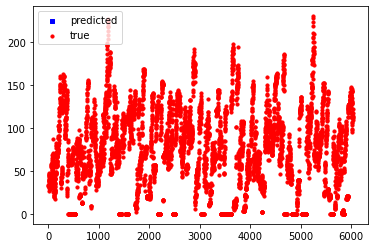

In [58]:
# Plots something for sure
x = range(len(pred))
y = range(100,200)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, pred, s=10, c='b', marker="s", label='predicted')
ax1.scatter(x, true, s=10, c='r', marker="o", label='true')
plt.legend(loc='upper left')
plt.show()

In [60]:
mse_list

[7534.79297454455,
 8048412673210903.0,
 4.762997090892397e+28,
 2.8187100002241832e+41,
 1.668093831204757e+54,
 9.871668349997189e+66,
 5.841987674155866e+79,
 3.45724945115268e+92,
 2.0459772314091003e+105,
 1.2107957179800222e+118,
 7.165408530324059e+130,
 4.240441111907529e+143,
 2.509464847322857e+156,
 1.4850846064730022e+169,
 8.788631929775443e+181,
 5.2010539238238726e+194,
 3.077949120485567e+207,
 1.821509818404778e+220,
 1.0779573958719585e+233,
 6.379280175018167e+245,
 3.7752155796900944e+258,
 2.2341474715200507e+271,
 1.3221536145782632e+284,
 7.824417156102125e+296,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf]